# Taking a 2D image using spin-echo sequences

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from main import measure, GAMMA
from helper import view, view_phase
import numba_ft

# Setup
## Load the sample2
Two different versions of sample2 can be loaded.
1. `sample2.npy` Size $100 \times 100$
2. `sample2_modi.npy`Size $300 \times 300$

The second one takes a lot longer to simulate but the result resembles the reality far better. 
Since this simulation takes a lot of time itself the first one will be used.

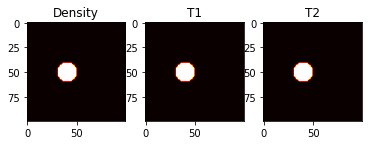

In [2]:
sample = np.load(f"{os.getcwd()}/sample.npy")
view(sample)

## Setup magnetic field
It is necessary to add some noise to the magnetic field. Otherwise, the magnetic
field will be perfectly homogenous, which is unrealistic. Furthermore, is a slight
inhomogeneity in the magnetic field necessary for spin echos.

In [3]:
b0 = np.zeros(sample.shape[:2])
b0.fill(0.43)
b0 += np.random.normal(0, 1e-6, b0.shape)

f_larmor = GAMMA * 0.43

Setup phases and measurement time

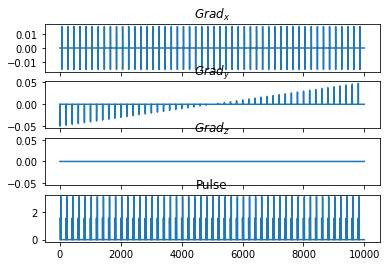

In [4]:
tfactor = 50  # how many steps per 1ms
recotime = 200  # Time between two measuerments in ms

nphases = 50  # FIXME:
nsamples = 50  # FIXME:
echotime = 30 # echtime in ms

phase_ampl = 0.002
phase_delay = 5 # ms

t = nphases * recotime

# phases = [Gradx, Grady, Gradz, Pulse]
ts = np.linspace(0, t, t * tfactor)
phases = np.zeros((t * tfactor, 4))

time = 0
gets = []
for i_phase in range(nphases):
    # pulses
    phases[tfactor * time, 3] = np.pi / 2  # 90 degree puls
    phases[tfactor * (time + echotime), 3] = np.pi  # 180 degree puls

    # phase encoding in y direction
    phases[tfactor * (time + 1):tfactor * (time + phase_delay), 1] = phase_ampl * (i_phase - nphases // 2)

    # frequency encoding in z direction
    phases[tfactor * (time + 2 * echotime)  - nsamples:tfactor * (time + 2 * echotime) - nsamples // 2, 0] = -0.015
    phases[tfactor * (time + 2 * echotime)  - nsamples // 2:tfactor * (time + 2 * echotime) + nsamples // 2, 0] = 0.015


    gets.append(list(range(tfactor * (time + 2 * echotime) - nsamples // 2, tfactor * (time + 2 * echotime) + nsamples // 2)))
    time += recotime


view_phase(phases, tfactor)

# Measurement & Results
## Measurement with gradient along x

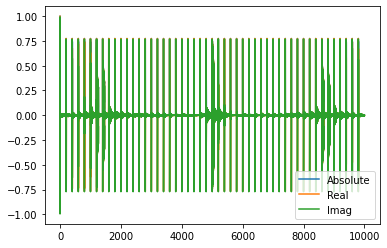

In [5]:
signal = measure(sample, b0, tfactor, phases, f_larmor)
plt.plot(ts, np.abs(signal), label="Absolute")
plt.plot(ts, np.real(signal), label="Real")
plt.plot(ts, np.imag(signal), label="Imag")
plt.legend()
plt.show()


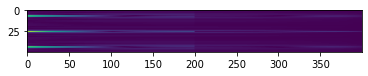

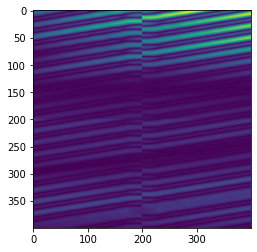

In [6]:
f = np.linspace(-1000, 1000, 400, True)

# row-wise fourier transform
times = [[e / tfactor * 1e-3 for e in get] for get in gets]
image = np.array([numba_ft.ft_uneven(signal[get], np.array(time), 2 * np.pi * f, 1, 0) for get, time in zip(gets, times)])

# plt.plot(times[0], np.abs(signal[gets[0]]))
plt.imshow(np.abs(image))
plt.show()

# column-wise fourier transform
time = np.array([2 * phase_ampl / nphases * (i_phase - nphases // 2) for i_phase in range(nphases)])
image = np.array([numba_ft.ft_uneven(image[:,i], np.array(time), 2 * np.pi * f, 1, 0) for i in range(image.shape[1])])

plt.imshow(np.abs(image))
plt.show()